# Kernelized Classification

Both perceptron and SVM can be kernelized, i.e. the output of the regressor can be passed through the sign function. 

$$ \hat{y} = \text{sign} \left[ \sum_{i=1}^N \alpha_i y_i K(x_i, x) \right] $$ and a perceptron loss applied to the difference between the predictor and the true value. 

The perceptron loss can be posed as:

$$ L(\alpha;x_j, y_j) = \max \left\{0, -\sum_{j=1}^N y_j \alpha_i K(x_i, x_j) \right\} $$ 

The parameters are updated as follows: 
If $\hat{y}(x) \neq y(x)$, set $\alpha \gets \alpha + \eta_t$.  

In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

%matplotlib inline
%load_ext autoreload
%autoreload 2
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import IPython
from IPython.display import display, clear_output
from matplotlib import rcParams 
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

import numpy as np
import matplotlib.pyplot as plt

from utilities.util import gradient_descent
from utilities.load_data import linear_separable_data, circular_separable_data
from utilities import plot_helpers 
from utilities.classifiers import kNN
from utilities.kernels import LinearKernel, PolynomialKernel, GaussianKernel, PeriodicKernel, LaplacianKernel, SumKernel

from sklearn import svm
from sklearn import datasets


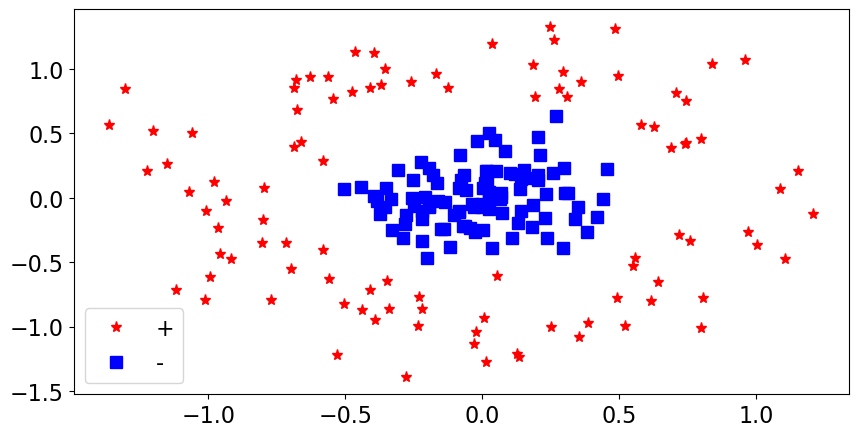

In [2]:
num_points = 100  # Number of points per class
noise = 0.2  # Noise Level (needed for data generation).

X, Y = circular_separable_data(num_points, noise=noise, offset=1)
fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': '+'}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-'}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
fig.legend();

## Kernelized Perceptron Demo

In [3]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

kernel_widget = ipywidgets.RadioButtons(options=['Linear', 'Polynomial-2', 'Polynomial-3', 'Gaussian', 'Laplacian'], 
                                        value='Linear',
                                        description='Kernel type:', style={'description_width': 'initial'})
bs_widget = ipywidgets.IntSlider(value=100, min=1, max=200, step=1, description='Batch Size:',
                                 style={'description_width': 'initial'}, continuous_update=False)
n_iter_widget = ipywidgets.IntSlider(value=20, min=5, max=50, step=1, description='Number of iterations:',
                                     style={'description_width': 'initial'}, continuous_update=False)
def kernelized_perceptron(kernel, batch_size, n_iter):
    if kernel == 'Linear':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=1, prediction=False)
    elif kernel == 'Polynomial-2':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=2, prediction=False)
    elif kernel == 'Polynomial-3':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=3, prediction=False)
    elif kernel == 'Gaussian':
        classifier = GaussianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)   
    elif kernel == 'Laplacian':
        classifier = LaplacianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)  
        
    alpha0 = 0 * np.random.randn(X.shape[0])

    opts = {'eta0': 0.5,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }
    try:
        alphas, indexes = gradient_descent(alpha0, classifier, opts=opts)

        fig = plt.subplot(111)
        opt = {'marker': 'r*', 'label': '+'}
        plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
        opt = {'marker': 'bs', 'label': '-'}
        plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

        contour_opts = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': False, 'n_classes': 2}
        opts = {'contour_opts': contour_opts}
        plot_helpers.classification_progression(X, Y, alphas, indexes, classifier, contour_plot=fig, options=opts)

    except KeyboardInterrupt:
        pass 
    
interact_manual(kernelized_perceptron, kernel=kernel_widget, batch_size=bs_widget, n_iter=n_iter_widget);

interactive(children=(RadioButtons(description='Kernel type:', options=('Linear', 'Polynomial-2', 'Polynomial-…

## Kernelized SVM Demo

In [4]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

def laplacian_kernel(X, Y, bw):
    rows = X.shape[0]
    cols = Y.shape[0]
    K = np.zeros((rows, cols))
    for col in range(cols):
        dist = bw * np.linalg.norm(X - Y[col, :], ord=1, axis=1)
        K[:, col] = np.exp(-dist)
    return K

# Our dataset and targets
n_samples = 200  # Number of points per class
tol = 1e-1

def kernelized_svm(dataset, kernel, reg, bw, deg, noise):
    if dataset is 'blobs':
        X, Y = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=noise, random_state=42)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
    elif dataset == 'xor':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([1, 1]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([1, 0]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
    
    elif dataset == 'periodic':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([0, 2]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([0, 3]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
        
    X = X[Y <= 1, :]
    Y = Y[Y <=1 ]
    Y[Y==0] = -1
        
    # Add the 1 feature.  
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    plot_support = True
    if kernel == 'poly':
        gamma = 1
        coef0 = 0
    elif kernel == 'sigmoid':
        gamma = np.power(10., bw)
        coef0 = 0
    elif kernel == 'rbf':
        gamma = np.power(10., -bw)
        coef0 = 0
    elif kernel == 'laplacian':
        gamma = np.power(10., -bw)
        coef0 = 0
        kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)
        plot_support = False

    classifier = svm.SVC(kernel=kernel, C=np.power(10., -reg), gamma=gamma, degree=deg, coef0=coef0, tol=tol)
    classifier.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()
    fig = plt.axes()
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
    if plot_support:
        plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=80,
                    facecolors='none', edgecolors='k')

    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    x_min = mins[0] - 1
    x_max = maxs[0] + 1
    y_min = mins[1] - 1
    y_max = maxs[1] + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]  
    Xtest = np.c_[XX.ravel(), YY.ravel(), np.ones_like(XX.ravel())]
    Z = classifier.decision_function(Xtest)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contourf(XX, YY, Z > 0, cmap=plt.cm.jet, alpha=0.3)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.99, 0, .99])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


interact(kernelized_svm, 
         dataset=['moons', 'blobs', 'circles',  'xor', 'periodic'],
         kernel=['rbf',  'poly', 'laplacian'], 
         reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),
         bw=ipywidgets.FloatSlider(value=0.5,
                                    min=-3,
                                    max=3,
                                    step=0.1,
                                    readout_format='.1f',
                                    description='Bandwidth 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
         deg=ipywidgets.IntSlider(
                         value=1,
                         min=1,
                         max=10, 
                         step=1,
                         description='Degree of Poly:',
                         style={'description_width': 'initial'}),
         noise=ipywidgets.FloatSlider(value=0.05,
                                    min=0.01,
                                    max=0.3,
                                    step=0.01,
                                    readout_format='.2f',
                                    description='Noise level:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        );

<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/8z/h732mzmx1g36_qdfvy0t3vt80000gn/T/ipykernel_3504/3921035155.py:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'blobs':
/var/folders/8z/h732mzmx1g36_qdfvy0t3vt80000gn/T/ipykernel_3504/3921035155.py:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dataset is 'circles':
/var/folders/8z/h732mzmx1g36_qdfvy0t3vt80000gn/T/ipykernel_3504/3921035155.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dataset is 'moons':


interactive(children=(Dropdown(description='dataset', options=('moons', 'blobs', 'circles', 'xor', 'periodic')…

## KNN

The K-Nearest Neighbors classifier is very easy. The label of a next sample is the label most voted by the $k$ training samples that are closer to this sample.

A simple implementation is $$\hat{y} = \text{sign}\left\{\sum_{i \in \mathcal{N}_k (x)} K(x_i, x) y_i\right\},$$

where $\mathcal{N}_k (x)$ is the set with the $k$ closest neighbours of $x$, $K(x_i, x)$ is a weighting coefficient, and $y_i$ is the label of example $i$. Usually $K(\cdot, \cdot)$ can be a kernel function, that measures the similarity between two points. In the vanilla k-NN method the kernel is just the identity function. 


In [5]:
k_widget = ipywidgets.IntSlider(value=1, min=1, max=9, step=1, description='k',
                                style={'description_width': 'initial'}, continuous_update=False)
noise_widget = ipywidgets.FloatSlider(value=0.4, min=0, max=1, step=0.1, description='Noise',
                                      style={'description_width': 'initial'}, continuous_update=False)

def change_k_nn(k, noise):
    np.random.seed(0)
    X, Y = circular_separable_data(num_points, noise=noise, offset=1)
    classifier = kNN(X, Y, k)
    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    opt = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$'}
    plot_helpers.plot_classification_boundaries(X, classifier, fig=fig, options=opt)

interact(change_k_nn, k=k_widget, noise=noise_widget);


interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=9, min=1, style=SliderS…

# Kernelized Regression

The true response function $f: x \to y$ is defined as: $$ f(x) = x +  \sin(5x) - \cos(10x),$$ 
and measured outputs $y$ at inputs $x$ are corrupted with zero mean gaussian noise. 

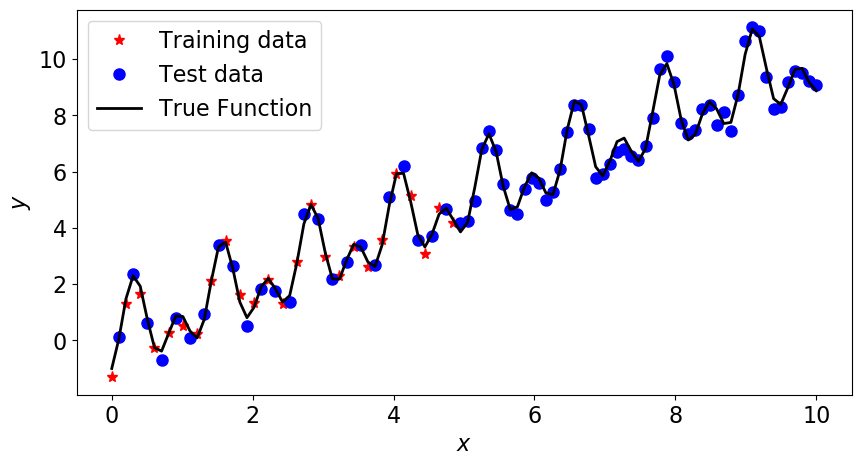

In [6]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

num_points = 100
xmin = 0
xmax = 10
noise = 0.2

X = np.reshape(np.linspace(xmin, xmax, num_points), [-1, 1])  # create 1-D input data
F = X + np.sin(X * 5) - np.cos(X * 10)  # true functional response
Y = F + noise * np.random.randn(num_points, 1)  # generate noisy labels

# Training Data
training_idx = np.arange(0, 50, 2)
Xtr = X[training_idx, :]
Ytr = Y[training_idx]

# Test Data
test_idx = np.setdiff1d(np.arange(0, num_points, 1), training_idx)
Xtest = X[test_idx, :]
Ytest = Y[test_idx]

fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': 'Training data'}
plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
opt = {'marker': 'bo', 'label': 'Test data'}
plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)
opt = {'marker': 'k-', 'label': 'True Function', 'x_label': '$x$', 'y_label': '$y$', 'legend': True, 'linewidth': 2}
plot_helpers.plot_data(X, F, fig=fig, options=opt)


In [ ]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16
def kernel_regression(kernel, reg, deg, noise, bw, frequency):
    kernel_str = '+'.join(kernel)
    np.random.seed(0)
    X = np.reshape(np.linspace(xmin, xmax, num_points), [-1, 1])  # create 1-D input data
    F = X + np.sin(X * 5) - np.cos(X * 10)  # true functional response
    Y = F + noise * np.random.randn(num_points, 1)  # generate noisy labels
    
    # Training Data
    training_idx = np.arange(0, 50, 2)
    Xtr = X[training_idx, :]
    Ytr = Y[training_idx]
    
    test_idx = np.setdiff1d(np.arange(0, num_points, 1), training_idx)
    Xtest = X[test_idx, :]
    Ytest = Y[test_idx]

    
    kernels = []
    if "Polynomial" in kernel:
        kernels.append(PolynomialKernel)
    if 'Laplacian' in kernel:
        kernels.append(LaplacianKernel)
    if "Gaussian" in kernel:
        kernels.append(GaussianKernel)
    if "Periodic" in kernel:
        kernels.append(PeriodicKernel)    
    regressor = SumKernel(kernels, Xtr, Ytr, reg=reg, bw=bw, freq=frequency, deg=deg)
    
    regressor.calculate_alpha(Ytr)
    ypr = regressor.predict(X)

    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': 'Training data'}
    plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
    opt = {'marker': 'bo', 'label': 'Test data'}
    plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)
    opt = {'marker': 'g-', 'label': kernel_str + ' Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True, 'linewidth': 3}
    plot_helpers.plot_data(X, ypr, fig=fig, options=opt)
    
    opt = {'marker': 'k-', 'label': 'True Function', 'x_label': '$x$', 'y_label': '$y$', 'legend': True, 'linewidth': 2}
    plot_helpers.plot_data(X, F, fig=fig, options=opt)

    fig.set_xlim([-1, 11])
    fig.set_ylim([-1, 11])


interact(kernel_regression,
         kernel=ipywidgets.SelectMultiple(
             options=['Polynomial', 'Laplacian', 'Gaussian', 'Periodic'],
             value=['Polynomial',],
         ),
         reg=ipywidgets.FloatLogSlider(
             value=-1,
             min=-6,
             max=3,
             step=1e-12,
             readout_format='.6f',
             description='Regularization:',
             style={'description_width': 'initial'},
             continuous_update=False),
         deg = ipywidgets.IntSlider(
             value=1,
             min=1,
             max=10, 
             step=1,
             description='Degree of Polynomial kernel:',
             style={'description_width': 'initial'}),
         bw=ipywidgets.FloatSlider(
             value=0.2,
             min=0.01,
             max=3,
             step=0.01,
             readout_format='.3f',
             description='Kernel Width:',
             style={'description_width': 'initial'},
             continuous_update=False),
         frequency=ipywidgets.FloatSlider(
             value=1,
             min=0.01,
             max=3,
             step=0.01,
             readout_format='.3f',
             description='Periodic Freq:',
             style={'description_width': 'initial'},
             continuous_update=False),
         noise=ipywidgets.FloatSlider(value=0.2, min=0, max=1)
         );


## Parameter Selection

In [ ]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

def parameter_variation(kernel, reg=0.05, kernel_width=5, frequency=1):
    if kernel == 'Laplacian':
        regressor = LaplacianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Gaussian':
        regressor = GaussianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Periodic':
        regressor = PeriodicKernel(Xtr, Ytr, reg=reg, bw=kernel_width, freq=frequency)
    regressor.calculate_alpha(Ytr)
    ypr = regressor.predict(X)
    
    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': 'Training data'}
    plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
    opt = {'marker': 'bo', 'label': 'Test data'}
    plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)

    opt = {'marker': 'g-', 'label': 'Gaussian Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True}
    plot_helpers.plot_data(X, ypr, fig=fig, options=opt)


interact(parameter_variation,
         kernel=['Laplacian', 'Gaussian', 'Periodic'],
         kernel_width=ipywidgets.FloatSlider(
             value=0.2,
             min=0.01,
             max=10,
             step=0.01,
             readout_format='.3f',
             description='Kernel Width:',
             style={'description_width': 'initial'},
             continuous_update=False),
         reg=ipywidgets.FloatSlider(
             value=1e-2,
             min=0,
             max=1,
             step=1e-3,
             readout_format='.3f',
             description='Regularization Coefficient:',
             style={'description_width': 'initial'},
             continuous_update=False),
         frequency=ipywidgets.FloatSlider(
             value=0.1,
             min=0.1,
             max=2,
             step=1e-3,
             readout_format='.3f',
             description='Periodic Frequency:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );


## Kernelized SGD

In [ ]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

def kernelized_sgd():
    regressor = GaussianKernel(Xtr, Ytr, reg=0.0, bw=0.2)
    alpha0 = np.random.randn(Xtr.shape[0])

    opts = {'eta0': 1,
            'n_iter': 50,
            'batch_size': 5,
            'n_samples': Xtr.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }
    try:
        alphas, indexes = gradient_descent(alpha0, regressor, opts=opts)

        fig = plt.subplot(111)
        opt = {'marker': 'r*', 'label': 'Training data'}
        plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
        opt = {'marker': 'bo', 'label': 'Test data'}
        plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)

        opt = {'marker': 'g-', 'label': 'Gaussian Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True, 'sgd_point': True}
        plot_helpers.kernelized_regression_progression(X, Xtr, Ytr, alphas, indexes, regressor, fig=fig, options=opt)
    except KeyboardInterrupt:
        pass
    
interact_manual(kernelized_sgd);